# Athena Rationales Global

In [1]:
from pathlib import Path
import csv
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import functools

pd.options.display.float_format = '{:.2f}'.format

In [2]:
from tokenizers import ByteLevelBPETokenizer
import torch
import importlib
from fairseq.models.transformer import TransformerModel

In [3]:
import warnings
from matplotlib import colors
import os
from rationalization import rationalize_lm, rationalize_conditional_model

In [4]:
def param_default():
    corpus = 'fm_fc_ms_ff' #<-- Scope
    data_path = Path('../athena-datasets/' + corpus + '/')
    data_path_raw = Path('../athena-datasets/' + corpus + '/raw/')
    tokenizer_path = Path('../tokenizer/')
    return {
        'bpe_path' : tokenizer_path / 'universal_tokenizer/universal_tokenizer/roberta_aug_spaces',
        'eval_raw': [data_path_raw / 'eval/input.methods.txt',
                        data_path_raw / 'eval/output.tests.txt'],
        'test_raw': [data_path_raw / 'test/input.methods.txt', 
                        data_path_raw / 'test/output.tests.txt'],
        'train_raw': [data_path_raw / 'train/input.methods.txt', 
                        data_path_raw / 'train/output.tests.txt'],
        'data_labels' : ['eval_raw','test_raw','train_raw'],
        'output_pandas' : data_path / 'pandas/',
        'out_processed' : '/datasets/out_processed/',
        'model_name_or_path' : 'models/checkpoint_dir_01/models/', #Model Path
        'checkpoint_file': 'checkpoint_best.pt', #Model
        'data_preprocessed':'/home/davidna/data/dummy/sequential-rationales/fairseq/fairseq/data-bin/bins/' 
    }

In [5]:
params = param_default()
params['checkpoint_file']

'checkpoint_best.pt'

In [6]:
params['eval_raw']

[PosixPath('../athena-datasets/fm_fc_ms_ff/raw/eval/input.methods.txt'),
 PosixPath('../athena-datasets/fm_fc_ms_ff/raw/eval/output.tests.txt')]

## Rationalizations Utilities

In [7]:
rationalization = importlib.import_module("sequential-rationales.huggingface.rationalization")
rationalize = rationalization.rationalize_lm
warnings.filterwarnings("ignore")

## Universal Tokenizer

In [8]:
def load_tokenizer(bpe_path):
    return ByteLevelBPETokenizer(str(bpe_path)+'-vocab.json',str(bpe_path)+'-merges.txt')

In [9]:
def lazy_decode(bpe_java):
    return bpe_java.replace(' ','').replace('Ġ',' ').replace('Ċ','\n')

In [10]:
def prettify_java(minified_java):
    "tries to undo Michele's minification. Works decently, although for loops and sets get newlines inserted, and there are no empty lines or comments"
    minified_java = minified_java.replace('{','{\n').replace('}','}\n').replace(';',';\n')
    num_indents = 0
    pretty_java = ''
    for line in minified_java.splitlines():
        if line.lstrip().startswith('}'):
            num_indents -= 1
        pretty_java += num_indents*'    '+line+'\n'
        if line.endswith('{'):
            num_indents += 1
        if line.endswith('}') and not line.lstrip().startswith('}'):
            num_indents -= 1
    return pretty_java

In [11]:
tokenizer = load_tokenizer(params['bpe_path'])

## Data Loading and Testing

In [12]:
#export
def method_size_vector( method_vector ):
    '''Return the size of the tokens for a give method based on id
        Assuming that method_vector is an array of tokens
    '''
    input_ids = [ len(mtd) for mtd in method_vector ]
    return input_ids

In [13]:
def super_set_code():
    data = {}
    for label in params['data_labels']:
        for val,path_data in enumerate(params[ label ]):
            df = pd.read_csv( path_data, sep="\n", header=None, names=[label+str(val)]) #reading file
            df[label+'_bpe'+str(val)] = [ enc.tokens for enc in tokenizer.encode_batch( df[label+str(val)].values ) ] #bpe
            df['method_size'+str(val)] = method_size_vector( df[label+'_bpe'+str(val)].values ) #counting tokens
            data[label+str(val)] =  df  
        #data[-1].columns = [ label ]
    return data

In [14]:
#super_data = super_set_code() #[WARNING] Use it when not computed! Otherwise use Loading Json

In [15]:
#super_data.keys()

In [16]:
# Loading Json Sets
def load_checkpoint_1():
    super_df = {}
    for label in params['data_labels']:
        for val, _ in enumerate(params[ label ]):
            super_df[ label+str(val) ] = pd.read_json( params['output_pandas'] / (label+str(val) +'.json')  )
            print("read:",label+str(val))
    return super_df

In [17]:
super_data = load_checkpoint_1()

read: eval_raw0
read: eval_raw1
read: test_raw0
read: test_raw1
read: train_raw0
read: train_raw1


In [18]:
super_data['test_raw0'].head(1) #Source

,test_raw0,test_raw_bpe0,method_size0
0,DateUtils { public static Date yearStart() { f...,"[Date, Ut, ils, Ġ{, Ġpublic, Ġstatic, ĠDate, Ġ...",227


In [19]:
super_data['test_raw1'].head(1) #Target

,test_raw1,test_raw_bpe1,method_size1
0,@Test public void yearStart() { Date date = Da...,"[@, Test, Ġpublic, Ġvoid, Ġyear, Start, (), Ġ{...",61


## Model Loading and Testing

In [20]:
#Loading a pretrain model
model = TransformerModel.from_pretrained(
  model_name_or_path = params['model_name_or_path'],
  checkpoint_file = params['checkpoint_file'],
  #data_name_or_path = params['data_preprocessed']
)

In [21]:
## Move model to GPU if available and trigger evaluation mode
if torch.cuda.is_available():
  model.cuda()
model.eval()

GeneratorHubInterface(
  (models): ModuleList(
    (0): BARTModel(
      (encoder): TransformerEncoderBase(
        (dropout_module): FairseqDropout()
        (embed_tokens): Embedding(50348, 512, padding_idx=1)
        (embed_positions): SinusoidalPositionalEmbedding()
        (layers): ModuleList(
          (0): TransformerEncoderLayerBase(
            (self_attn): MultiheadAttention(
              (dropout_module): FairseqDropout()
              (k_proj): Linear(in_features=512, out_features=512, bias=True)
              (v_proj): Linear(in_features=512, out_features=512, bias=True)
              (q_proj): Linear(in_features=512, out_features=512, bias=True)
              (out_proj): Linear(in_features=512, out_features=512, bias=True)
            )
            (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (dropout_module): FairseqDropout()
            (activation_dropout_module): FairseqDropout()
            (fc1): Linear(in_features=512,

In [22]:
model.model = model.models[0]

In [23]:
model.device

device(type='cuda', index=0)

In [24]:
MAX_TOKENS = 1023 ## HARDCODED <-----
def joining_encode_tokens( arr_tokens, model ):
    if len(arr_tokens) > MAX_TOKENS:
        arr_tokens = arr_tokens[0:MAX_TOKENS]
    focal_code = " ".join(arr_tokens)
    return model.encode( focal_code )

In [25]:
FLAG_SAMPLING = True #<---- HARDCODED
if FLAG_SAMPLING:
    SIZE_SAMPLING = 100 #<---- HARDCODED
    input_tokens = [ joining_encode_tokens(arr_sample, model=model) for arr_sample in super_data['test_raw0'].test_raw_bpe0.values[:SIZE_SAMPLING] ]
else:
    input_tokens = [ joining_encode_tokens(arr_sample, model=model) for arr_sample in super_data['test_raw0'].test_raw_bpe0.values]

In [26]:
len(input_tokens)

100

In [27]:
input_tokens[1]

tensor([39525, 41967,  5290, 25522,   285, 25156, 10566,    76, 18547, 43048,
        25522,   507,  4275, 23943, 15117, 29702,  7127,  5457,    92,  4275,
        23943, 15117, 29702,  1640,  3048,  4397,  7127,     4,  4917,  1640,
          975, 27757,     6,   112,  4397,  7127,     4,  8738,  1640,  2774,
         1215, 21600,  1215,   975, 27757,     6,   112,  4397,  7127,     4,
         4917,  1640,  2774,  1215, 21600,  1215,   975, 27757,     6,   111,
          134,  4397,   671,  7127,     4,  6460, 14699, 47006, 35524, 25156,
        10566,   452, 47006, 25156, 10566,  2350, 47006, 25156, 10566,  1606,
        41077,  1640,  6156,  6979,   360,     6,   507, 29419,    31,  4397,
        25156, 10566,  1606, 41077,  1640,  6156,  6979,   360,     6,   507,
        10566,    31,  4397, 25156, 10566,  1606, 41077,  1640,  6156,  6979,
          360,     6,   507,   251,    31,  4397, 25156, 10566,  1606, 17312,
        15561,  1640,  6156,  6979,   377,     6,   507, 29419, 

In [28]:
SAMPLES = 1 #<---- Hardocoded
MAX_GEN_TOK = 100

In [29]:
def sample_generation(input, model):
    generated_input =  model.generate( 
        input, 
        maxlen=MAX_GEN_TOK, ##WARNING, This parameter is not working
        max_length=SAMPLES, 
        do_sample=False, 
        pad_token_id=50256 ) ## HARDCODED
    return generated_input[0]['tokens'][:MAX_GEN_TOK]

In [30]:
#TODO limit the number of tokens generated
#WARNING TIME CONSUMING
arr_generated_input = [ sample_generation(input, model=model) for input in input_tokens ]

In [31]:
decoded = model.decode(arr_generated_input[0])
decoded

'@ Test Ġpublic Ġvoid Ġtest Year Start () Ġthrows ĠException Ġ{ ĠDate Ġdate Ġ= ĠDate Ut ils . year Start (); Ġassert Not Null ( date ); Ġassert Equ als ( date . get Time (), Ġdate . get Time ()); Ġassert Equ als ( date . get Time (), Ġdate . get Time ()); Ġ}'

In [32]:
prettify_java( lazy_decode( decoded ) )

'@Test public void testYearStart() throws Exception {\n     Date date = DateUtils.yearStart();\n     assertNotNull(date);\n     assertEquals(date.getTime(), date.getTime());\n     assertEquals(date.getTime(), date.getTime());\n }\n'

In [33]:
#If the model is not fine-tuned or compatible, it will rise an error
#Bear in mind that Athena is a Translation model (not a language one)
def rationalize_model(input_ids, generated_sequence, model, verbose=True):
    all_source_rationales, all_target_rationales, log = rationalize_conditional_model(
    model = model, 
    source_tokens = input_ids.to(model.device),
    target_tokens = generated_sequence, 
    verbose=verbose,
    max_steps=1024 #Max number of steps for greedy rationalization
    )
    return all_source_rationales, all_target_rationales, log 

In [34]:
arr_log = []
for index, gen_sampled in enumerate( arr_generated_input ):
    _, _, log = rationalize_model(
        input_ids = input_tokens[index], 
        generated_sequence = arr_generated_input[index], 
        model = model)
    arr_log.append(log)

All source tokens: ['Date', 'Ut', 'ils', 'Ġ{', 'Ġpublic', 'Ġstatic', 'ĠDate', 'Ġyear', 'Start', '()', 'Ġ{', 'Ġfinal', 'ĠGreg', 'orian', 'Cal', 'endar', 'Ġcalendar', 'Ġ=', 'Ġnew', 'ĠGreg', 'orian', 'Cal', 'endar', '(', 'US', ');', 'Ġcalendar', '.', 'set', '(', 'DAY', '_', 'OF', '_', 'Y', 'EAR', ',', 'Ġ1', ');', 'Ġreturn', 'Ġcalendar', '.', 'get', 'Time', '();', 'Ġ}', 'Ġstatic', 'ĠDate', 'Ġtoday', '();', 'Ġstatic', 'ĠDate', 'Ġyesterday', '();', 'Ġstatic', 'ĠDate', 'Ġadd', 'Days', '(', 'final', 'Ġint', 'Ġdays', ',', 'Ġfinal', 'ĠCalendar', 'Ġfrom', ');', 'Ġstatic', 'ĠDate', 'Ġadd', 'Days', '(', 'final', 'Ġint', 'Ġdays', ',', 'Ġfinal', 'ĠDate', 'Ġfrom', ');', 'Ġstatic', 'ĠDate', 'Ġadd', 'Days', '(', 'final', 'Ġint', 'Ġdays', ',', 'Ġfinal', 'Ġlong', 'Ġfrom', ');', 'Ġstatic', 'ĠDate', 'Ġadd', 'Mon', 'ths', '(', 'final', 'Ġint', 'Ġmonths', ',', 'Ġfinal', 'ĠCalendar', 'Ġfrom', ');', 'Ġstatic', 'ĠDate', 'Ġadd', 'Mon', 'ths', '(', 'final', 'Ġint', 'Ġmonths', ',', 'Ġfinal', 'ĠDate', 'Ġfrom', ');',

In [35]:
arr_code_rationales = [ log['rationalizations'] for log in arr_log ]
arr_code_rationales = sum(arr_code_rationales,[])

In [36]:
len(arr_code_rationales)

7646

In [37]:
#Creating pandas_1 {p_rationale}
rational = lambda list_log,typeset: [ (dict_tok['added_token_text'],round(dict_tok['true_token_prob'],6)) for dict_tok in list_log if dict_tok['from']==typeset]
log_from = lambda log_row,typeset: [(log_dict['added_token_text'],log_dict['true_token_prob']) for log_dict in log_row if log_dict['from']==typeset] #Typeset

log_position = lambda log_row,typeset: [log_dict['added_token_position'] for log_dict in log_row if log_dict['from']==typeset] #Position of the Rationale
log_prediction = lambda log_row,typeset: [log_dict['true_token_prob'] for log_dict in log_row if log_dict['from']==typeset] #Rationale Prob


In [38]:
p_rationale = pd.DataFrame()

p_rationale['goal_token'] = [dict_token['goal_word'] for dict_token in arr_code_rationales]

p_rationale['typesets_tgt'] = [ log_from(log_row,'target') for log_row in [dict_token['log'] for dict_token in arr_code_rationales]]
p_rationale['typesets_src'] = [ log_from(log_row,'source') for log_row in [dict_token['log'] for dict_token in arr_code_rationales]]


p_rationale['rationale_pos_tgt'] = [ log_position(log_row,'target') for log_row in [dict_token['log'] for dict_token in arr_code_rationales]]
p_rationale['rationale_pos_src'] = [ log_position(log_row,'source') for log_row in [dict_token['log'] for dict_token in arr_code_rationales]]

p_rationale['rationale_prob_tgt'] = [ log_prediction(log_row,'target') for log_row in [dict_token['log'] for dict_token in arr_code_rationales]]
p_rationale['rationale_prob_src'] = [ log_prediction(log_row,'source') for log_row in [dict_token['log'] for dict_token in arr_code_rationales]]

In [39]:
p_rationale.head(2)

,goal_token,typesets_tgt,typesets_src,rationale_pos_tgt,rationale_pos_src,rationale_prob_tgt,rationale_prob_src
0,Test,"[(@, 0.9980469942092896)]",[],[0],[],[0.9980469942092896],[]
1,Ġpublic,"[(Test, 0.9563336968421936)]",[],[1],[],[0.9563336968421936],[]


In [40]:
def print_heatmap(np_rationales, fig_size = (10,10), font = 15,
                yticklabels=log['target_tokens_text'], xticklabels=log['source_tokens_text']):
        plt.rcParams.update({'font.size': font})
        ax = plt.axes()
        sns.set(rc = {'figure.figsize':fig_size})
        sns.heatmap(np_rationales, cmap="YlGnBu", 
                yticklabels=yticklabels, 
                xticklabels=xticklabels,
                ax=ax)
        plt.show
        pass

## Ratioanales by General Taxonomy

In [41]:
#export
def token_taxonomy() -> dict:
    return {
  "blocks": {
    "<{>": "{",
    "<}>": "}",
    "<[>": "[",
    "<]>": "]",
    "<(>": "(",
    "<)>": ")",
    "<;>": ";",
    "<return>": "return"
  },
  "exceptions": {
    "<catch>": "catch",
    "<try>": "try",
    "<finally>": "finally",
    "<throw>": "throw",
    "<throws>": "throws"
  },
  "oop": {
    "<class>": "class",
    "<instanceof>": "instanceof",
    "<interface>": "interface",
    "<private>": "private",
    "<protected>": "protected",
    "<public>": "public",
    "<abstract>": "abstract",
    "<extends>": "extends",
    "<package>": "package",
    "<this>": "this",
    "<implements>": "implements",
    "<import>": "import",
    "<new>": "new",
    "<super>": "super"
  },
  "tests": {
    "<assert>": "assert"
  },
  "declarations": {
    "<native>": "native",
    "<static>": "static",
    "<synchronized>": "synchronized",
    "<transient>": "transient",
    "<volatile>": "volatile",
    "<void>": "void",
    "<final>": "final",
    "<enum>": "enum"
  },
  "conditionals": {
    "<else>": "else",
    "<if>": "if",
    "<switch>": "switch",
    "<case>": "case",
    "<default>": "default"
  },
  "loops": {
    "<break>": "break",
    "<do>": "do",
    "<for>": "for",
    "<while>": "while",
    "<continue>": "continue"
  },
  "operators": {
    "<=>": "=",
    "<+>": "+",
    "<->": "-",
    "<*>": "*",
    "</>": "/",
    "<%>": "%",
    "<++>": "++",
    "<-->": "--",
    "<!>": "!",
    "<==>": "==",
    "<!=>": "!=",
    "<greater_equal>": ">=",
    "<lesser_equal>": "<=",
    "<&&>": "&&",
    "<||>": "||",
    "<?>": "?",
    "<:>": ":",
    "<~>": "~",
    "<double_lesser>": "<<",
    "<double_greater>": ">>",
    "<triple_greater>": ">>>",
    "<&>": "&",
    "<^>": "^",
    "<|>": "|"
  },
  "datatypes": {
    "<byte>": "byte",
    "<char>": "char",
    "<float>": "float",
    "<boolean>": "boolean",
    "<double>": "double",
    "<int>": "int",
    "<long>": "long",
    "<short>": "short",
    "<strictfp>": "strictfp"
  },
  "extra_tokens": {
    "<@>": "@",
    "<...>": "...",
    "<null>": "null",
    "<true>": "true",
    "<false>": "false",
    "<n>": "\n"
  }
}

In [42]:
#Map-Reduce Aggregation by Taxonomy
def map_rationale_by_tax(arr_typeset, tkn_taxonomy, non_stringent = True):
    list_category_prob = []
    list_category_token = []
    for typeset_row in arr_typeset: #Iterating rationales
        #print(typeset_row)
        dict_category_prob = {}
        dict_category_token = {}
        for category in tkn_taxonomy.keys(): #Iterating on Tax-Categories
            set_elems = set( tkn_taxonomy[category].values() )
            if non_stringent:
                set_elems = set_elems.union( set(['Ġ'+tok_elem for tok_elem in set_elems]) )
            dict_category_prob[category] = [ token_tuple[1] for token_tuple in typeset_row if token_tuple[0] in set_elems ]
            dict_category_token[category] = [ token_tuple for token_tuple in typeset_row if token_tuple[0] in set_elems ]
        list_category_prob.append(dict_category_prob) 
        list_category_token.append(dict_category_token)  
    return list_category_prob, list_category_token

In [43]:
tkn_taxonomy = token_taxonomy()

In [44]:
list_category_prob_tgt, list_category_token_tgt = map_rationale_by_tax( arr_typeset=p_rationale.typesets_tgt.values, 
                                                tkn_taxonomy=tkn_taxonomy )
list_category_prob_src, list_category_token_src = map_rationale_by_tax( arr_typeset=p_rationale.typesets_src.values, 
                                                tkn_taxonomy=tkn_taxonomy )

In [45]:
p_rationale['category_prob_tgt'] = list_category_prob_tgt
p_rationale['category_token_tgt'] = list_category_token_tgt

p_rationale['category_prob_src'] = list_category_prob_src
p_rationale['category_token_src'] = list_category_token_src

In [46]:
p_rationale.head(1)

,goal_token,typesets_tgt,typesets_src,rationale_pos_tgt,rationale_pos_src,rationale_prob_tgt,rationale_prob_src,category_prob_tgt,category_token_tgt,category_prob_src,category_token_src
0,Test,"[(@, 0.9980469942092896)]",[],[0],[],[0.9980469942092896],[],"{'blocks': [], 'exceptions': [], 'oop': [], 't...","{'blocks': [], 'exceptions': [], 'oop': [], 't...","{'blocks': [], 'exceptions': [], 'oop': [], 't...","{'blocks': [], 'exceptions': [], 'oop': [], 't..."


In [47]:
dict_reduce_tax_prob_tgt = dict.fromkeys( tkn_taxonomy.keys(), [] )
dict_reduce_tax_prob_src = dict.fromkeys( tkn_taxonomy.keys(), [] )

In [48]:
non_stringent = True
for token_elem in set(p_rationale.goal_token.values):
    for category in tkn_taxonomy.keys(): #Iterating on Tax-Categories
        set_elems = set( tkn_taxonomy[category].values() )
        if non_stringent:
            set_elems = set_elems.union( set(['Ġ'+tok_elem for tok_elem in set_elems]) )
        if token_elem in set_elems:
            dict_reduce_tax_prob_tgt[category] = p_rationale[ p_rationale['goal_token'] == token_elem ].category_prob_tgt.values
            dict_reduce_tax_prob_src[category] = p_rationale[ p_rationale['goal_token'] == token_elem ].category_prob_src.values 

In [49]:
def merge_tax_dict(dict_a, dict_b):
    return {elem: dict_a[elem] + dict_b[elem]  for elem in dict_a}

In [50]:
def reduce_tax_dict( dict_reduce_tax_prob ):
    for tax in dict_reduce_tax_prob:
        if len(dict_reduce_tax_prob[tax]) > 0:
            dict_reduce_tax_prob[tax] = functools.reduce(lambda a, b: merge_tax_dict(a,b), dict_reduce_tax_prob[tax])
    pass


In [51]:
def reduce_tax_dict( dict_reduce_tax_prob ):
    return {lis: functools.reduce(lambda a, b: merge_tax_dict(a,b), dict_reduce_tax_prob[lis]) if len(dict_reduce_tax_prob[lis])>0 else {}  for lis in dict_reduce_tax_prob }

In [52]:
dict_reduce_tax_prob_tgt = reduce_tax_dict( dict_reduce_tax_prob= dict_reduce_tax_prob_tgt)
dict_reduce_tax_prob_src = reduce_tax_dict( dict_reduce_tax_prob= dict_reduce_tax_prob_src)

In [53]:
#Independent Variable: Source Rows
#Dependent Variable: Target Columns
np_rationales = np.zeros(
                ( len( tkn_taxonomy.keys() ), len( tkn_taxonomy.keys() ) ) )


In [54]:
for i, row_tax in enumerate( dict_reduce_tax_prob_tgt ):
        dict_inner = dict_reduce_tax_prob_tgt[row_tax]
        #print(i)
        if dict_inner:
            #print(i)
            for j, column_tax in enumerate( dict_inner ):
                #print(j)
                list_tax = dict_inner[column_tax]
                if list_tax:
                    np_rationales[i][j] = np.mean( list_tax ) #Agregation Function

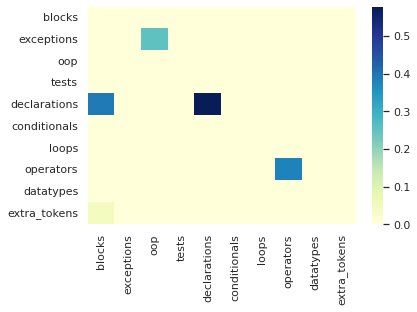

In [55]:
print_heatmap(
    np_rationales=np_rationales, 
    fig_size = (30,10), 
    font = 15,
    yticklabels=tkn_taxonomy.keys() , 
    xticklabels=tkn_taxonomy.keys() )

## General Statistics

In [56]:
#! pip install --upgrade gensim

In [57]:
import gensim.downloader as api
import json
info = api.info()

In [58]:
print(info.keys())

dict_keys(['corpora', 'models'])


In [59]:
for model_name, model_data in sorted(info['models'].items()):
    print(
        '%s (%d records): %s' % (
            model_name,
            model_data.get('num_records', -1),
            model_data['description'][:40] + '...',
        )
    )

__testing_word2vec-matrix-synopsis (-1 records): [THIS IS ONLY FOR TESTING] Word vecrors ...
conceptnet-numberbatch-17-06-300 (1917247 records): ConceptNet Numberbatch consists of state...
fasttext-wiki-news-subwords-300 (999999 records): 1 million word vectors trained on Wikipe...
glove-twitter-100 (1193514 records): Pre-trained vectors based on  2B tweets,...
glove-twitter-200 (1193514 records): Pre-trained vectors based on 2B tweets, ...
glove-twitter-25 (1193514 records): Pre-trained vectors based on 2B tweets, ...
glove-twitter-50 (1193514 records): Pre-trained vectors based on 2B tweets, ...
glove-wiki-gigaword-100 (400000 records): Pre-trained vectors based on Wikipedia 2...
glove-wiki-gigaword-200 (400000 records): Pre-trained vectors based on Wikipedia 2...
glove-wiki-gigaword-300 (400000 records): Pre-trained vectors based on Wikipedia 2...
glove-wiki-gigaword-50 (400000 records): Pre-trained vectors based on Wikipedia 2...
word2vec-google-news-300 (3000000 records): Pre-trai

In [70]:
model_clustering = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [73]:
model_clustering['Test']

array([-2.69531250e-01, -3.16406250e-01,  4.80957031e-02,  3.10058594e-02,
        8.59375000e-02,  8.25195312e-02,  3.95507812e-02, -3.88183594e-02,
        6.88476562e-02,  3.16406250e-01,  1.63085938e-01,  1.54296875e-01,
        4.39453125e-01,  1.71875000e-01,  9.76562500e-02, -1.32812500e-01,
       -1.34765625e-01,  2.23388672e-02,  9.61914062e-02,  1.94335938e-01,
       -2.17773438e-01, -2.59765625e-01, -1.04980469e-01, -1.90429688e-01,
        2.56347656e-02,  1.82617188e-01, -1.22070312e-01,  6.77490234e-03,
        4.60937500e-01, -2.05078125e-01,  1.05957031e-01,  4.88281250e-02,
       -3.39843750e-01,  3.63769531e-02,  1.05957031e-01,  2.55859375e-01,
       -3.37890625e-01,  1.06445312e-01,  1.90429688e-01, -6.17675781e-02,
       -1.21459961e-02, -8.39843750e-02,  5.15625000e-01,  1.39160156e-02,
       -2.14843750e-01,  4.27246094e-02, -2.22206116e-04,  6.98242188e-02,
       -2.55859375e-01,  3.06640625e-01, -3.76953125e-01,  1.51977539e-02,
       -1.36718750e-01,  

In [80]:
# Apply the word embedding model to the sentences
p_rationale['vec_token'] = p_rationale['goal_token'].apply( lambda x: model_clustering[ lazy_decode(x).strip() ] )

KeyError: "Key '()' not present"

In [79]:
lazy_decode('Ġpublic').strip()

'public'

In [60]:
p_rationale.head(1)

,goal_token,typesets_tgt,typesets_src,rationale_pos_tgt,rationale_pos_src,rationale_prob_tgt,rationale_prob_src,category_prob_tgt,category_token_tgt,category_prob_src,category_token_src
0,Test,"[(@, 0.9980469942092896)]",[],[0],[],[0.9980469942092896],[],"{'blocks': [], 'exceptions': [], 'oop': [], 't...","{'blocks': [], 'exceptions': [], 'oop': [], 't...","{'blocks': [], 'exceptions': [], 'oop': [], 't...","{'blocks': [], 'exceptions': [], 'oop': [], 't..."
